# LineageOT demo

This notebook runs a simulation of one of three flow fields, computes optimal transport couplings with and without lineage information, and compares their accuracy at predicting cells' ancestors and descendants.

In [1]:
# pip install git+https://github.com/aforr/LineageOT@master cvxopt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from ott.geometry.pointcloud import PointCloud
from jax import numpy as jnp
import seaborn as sns

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ot

import lineageot.simulation as sim
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf

In [4]:
# Choosing one of the three flow fields from the paper
# Uncomment the one you would like to simulate

# TODO(michalk8): extract into function
#flow_type = 'bifurcation'
flow_type = 'convergent'
#flow_type = 'partial_convergent'
#flow_type = 'mismatched_clusters'

In [5]:

# Setting simulation parameters
np.random.seed(257) 

if flow_type == 'bifurcation':
    timescale = 1
else:
    timescale = 100

x0_speed = 1/timescale


sim_params = sim.SimulationParameters(division_time_std = 0.01*timescale,
                                      flow_type = flow_type,
                                      x0_speed = x0_speed,
                                      mutation_rate = 1/timescale,
                                      mean_division_time = 1.1*timescale,
                                      timestep = 0.001*timescale
                                     )

# These parameters can be adjusted freely.
# As is, they replicate the plots in the paper for the fully convergent simulation.
mean_x0_early = 2
time_early = 7.4*timescale # Time when early cells are sampled
time_late = time_early + 4*timescale # Time when late cells are sampled
x0_initial = mean_x0_early -time_early*x0_speed
initial_cell = sim.Cell(np.array([x0_initial, 0, 0]), np.zeros(sim_params.barcode_length))
sample_times = {'early' : time_early, 'late' : time_late}



# Choosing which of the three dimensions to show in later plots
if flow_type == 'mismatched_clusters':
    dimensions_to_plot = [1,2]
else:
    dimensions_to_plot = [0,1]


## Running the simulation
%time sample = sim.sample_descendants(initial_cell.deepcopy(), time_late, sim_params)


CPU times: user 13.7 s, sys: 17 ms, total: 13.7 s
Wall time: 13.7 s


In [6]:
# Extracting trees and barcode matrices
true_trees = {'late':sim_inf.list_tree_to_digraph(sample)}
true_trees['late'].nodes['root']['cell'] = initial_cell

true_trees['early'] = sim_inf.truncate_tree(true_trees['late'], sample_times['early'], sim_params)

# Computing the ground-truth coupling
couplings = {'true': sim_inf.get_true_coupling(true_trees['early'], true_trees['late'])}

In [7]:
data_arrays = {'late' : sim_inf.extract_data_arrays(true_trees['late'])}
rna_arrays = {'late': data_arrays['late'][0]}
barcode_arrays = {'late': data_arrays['late'][1]}

rna_arrays['early'] = sim_inf.extract_data_arrays(true_trees['early'])[0]
num_cells = {'early': rna_arrays['early'].shape[0], 'late': rna_arrays['late'].shape[0]}

print("Times    : ", sample_times)
print("Number of cells: ", num_cells)

Times    :  {'early': 740.0, 'late': 1140.0}
Number of cells:  {'early': 64, 'late': 1024}


In [8]:
# Creating a copy of the true tree for use in LineageOT
true_trees['late, annotated'] = copy.deepcopy(true_trees['late'])
sim_inf.add_node_times_from_division_times(true_trees['late, annotated'])

sim_inf.add_nodes_at_time(true_trees['late, annotated'], sample_times['early']);

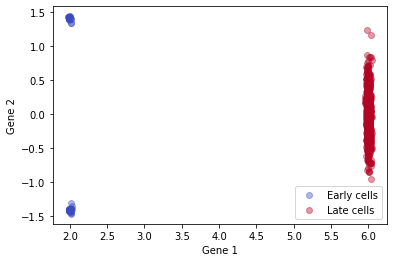

In [9]:
# Scatter plot of cell states

cmap = "coolwarm"
colors = [plt.get_cmap(cmap)(0), plt.get_cmap(cmap)(256)]
for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)


plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.legend();

In [10]:
# Infer ancestor locations for the late cells based on the true lineage tree

observed_nodes = [n for n in sim_inf.get_leaves(true_trees['late, annotated'], include_root=False)]
sim_inf.add_conditional_means_and_variances(true_trees['late, annotated'], observed_nodes)

ancestor_info = {'true tree':sim_inf.get_ancestor_data(true_trees['late, annotated'], sample_times['early'])}

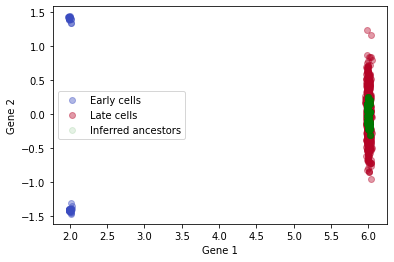

In [11]:
# Scatter plot of cell states, with inferred ancestor locations for the late cells

for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

plt.scatter(ancestor_info['true tree'][0][:,dimensions_to_plot[0]],
            ancestor_info['true tree'][0][:,dimensions_to_plot[1]],
            alpha = 0.1,
            label = 'Inferred ancestors',
            color = 'green')
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.legend();

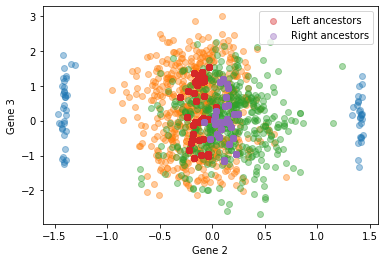

In [12]:
# To better visualize cases where there were two clusters at the early time point,
# we can color the late cells (and their inferred ancestors) by their cluster of origin
is_from_left = sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0][:,1] < 0
for a,label in zip([rna_arrays['early'], rna_arrays['late'][is_from_left,:], rna_arrays['late'][~is_from_left,:]], ['Early cells', 'Late cells from left', 'Late cells from right']):
    plt.scatter(a[:, 1], a[:, 2], alpha = 0.4)

plt.xlabel('Gene 2')
plt.ylabel('Gene 3')


for a, label in zip([ancestor_info['true tree'][0][is_from_left, :], ancestor_info['true tree'][0][~is_from_left, :]], ['Left ancestors', 'Right ancestors']):
    plt.scatter(a[:,1], a[:,2], alpha = 0.4, label = label)
plt.legend()

### Fitting a lineage tree to barcodes

In [13]:
%%time
# True distances
true_distances = {key:sim_inf.compute_tree_distances(true_trees[key]) for key in true_trees}


CPU times: user 1min 59s, sys: 29.4 ms, total: 1min 59s
Wall time: 1min 59s


In [14]:
# Estimate mutation rate from fraction of unmutated barcodes

rate_estimate = sim_inf.rate_estimator(barcode_arrays['late'], sample_times['late'])

print("Fraction unmutated barcodes: ", {key:np.sum(barcode_arrays[key] == 0)/barcode_arrays[key].size
                                        for key in barcode_arrays})
print()

print("Rate estimate: ", rate_estimate)
print("True rate: ", sim_params.mutation_rate/sim_params.barcode_length)
print("Rate accuracy: ", rate_estimate*sim_params.barcode_length/sim_params.mutation_rate)

Fraction unmutated barcodes:  {'late': 0.47311197916666664}

Rate estimate:  0.0006565115579693221
True rate:  0.0006666666666666666
Rate accuracy:  0.9847673369539832


In [15]:
# Compute Hamming distance matrices for neighbor joining

hamming_distances_with_roots = {'late':sim_inf.barcode_distances(np.concatenate([barcode_arrays['late'],
                                                                                         np.zeros([1,sim_params.barcode_length])]))}



In [16]:
# Compute neighbor-joining tree

fitted_tree = sim_inf.neighbor_join(hamming_distances_with_roots['late'])

In [17]:
# Annotate fitted tree with internal node times

sim_inf.add_leaf_barcodes(fitted_tree, barcode_arrays['late'])
sim_inf.add_leaf_x(fitted_tree, rna_arrays['late'])
sim_inf.add_leaf_times(fitted_tree, sample_times['late'])
sim_inf.annotate_tree(fitted_tree,
                  rate_estimate*np.ones(sim_params.barcode_length),
                  time_inference_method = 'least_squares');

     pcost       dcost       gap    pres   dres
 0: -6.3033e+08 -6.5015e+08  1e+08  2e-01  2e-01
 1: -6.2945e+08 -6.6103e+08  4e+07  4e-02  6e-02
 2: -6.2910e+08 -6.4660e+08  2e+07  1e-02  2e-02
 3: -6.3080e+08 -6.3880e+08  8e+06  4e-03  6e-03
 4: -6.3112e+08 -6.3682e+08  6e+06  3e-04  5e-04
 5: -6.3180e+08 -6.3502e+08  3e+06  1e-04  2e-04
 6: -6.3224e+08 -6.3378e+08  2e+06  3e-05  4e-05
 7: -6.3254e+08 -6.3282e+08  3e+05  1e-16  6e-16
 8: -6.3260e+08 -6.3262e+08  2e+04  1e-16  3e-16
 9: -6.3261e+08 -6.3261e+08  7e+02  1e-16  1e-15
10: -6.3261e+08 -6.3261e+08  3e+01  1e-16  3e-15
Optimal solution found.


In [18]:
# Add inferred ancestor nodes and states

sim_inf.add_node_times_from_division_times(fitted_tree)

sim_inf.add_nodes_at_time(fitted_tree, sample_times['early'])

observed_nodes = [n for n in sim_inf.get_leaves(fitted_tree, include_root = False)]
sim_inf.add_conditional_means_and_variances(fitted_tree, observed_nodes)

ancestor_info['fitted tree'] = sim_inf.get_ancestor_data(fitted_tree, sample_times['early'])

### Computing cost matrices

In [19]:
# Compute cost matrices for each method
coupling_costs = {}
coupling_costs['lineageOT, true tree'] = ot.utils.dist(rna_arrays['early'], ancestor_info['true tree'][0])@np.diag(ancestor_info['true tree'][1]**(-1))
coupling_costs['OT'] = ot.utils.dist(rna_arrays['early'], rna_arrays['late'])
coupling_costs['lineageOT, fitted tree'] = ot.utils.dist(rna_arrays['early'], ancestor_info['fitted tree'][0])@np.diag(ancestor_info['fitted tree'][1]**(-1))

early_time_rna_cost = ot.utils.dist(rna_arrays['early'], sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0])
late_time_rna_cost = ot.utils.dist(rna_arrays['late'], rna_arrays['late'])

In [20]:
geom_ot = Geometry(cost_matrix=jnp.array(coupling_costs['OT']))
geom_fitted = Geometry(cost_matrix=jnp.array(coupling_costs['lineageOT, fitted tree']))
geom_true = Geometry(cost_matrix=jnp.array(coupling_costs['lineageOT, true tree']))

In [21]:
geom_rnae = PointCloud(jnp.asarray(rna_arrays['early']))
geom_rnal = PointCloud(jnp.asarray(rna_arrays['late']))
e = jnp.array(true_distances['early'])
e /= e.max()
geom_tde = Geometry(cost_matrix=e)
l = jnp.array(true_distances['late'])
l /= l.max()
geom_tdl = Geometry(cost_matrix=l)

In [22]:
%%time
# Fit couplings with a range of entropy parameters
from moscot import GW, FusedGW, Unbalanced

epsilons = np.logspace(-2, 3, 15)  # original epsilons
epsilons = [1e-4, 1e-3, 1e-2, 1e-1]

couplings['OT'] = ot.emd([],[],coupling_costs['OT'])
couplings['lineageOT'] = ot.emd([], [], coupling_costs['lineageOT, true tree'])
couplings['lineageOT, fitted'] = ot.emd([], [], coupling_costs['lineageOT, fitted tree'])
# stil ent. regularized
gwe = GW(epsilon=None).fit(geom_rnae, geom_tdl)
couplings['gwe'] = np.array(gwe.matrix)
gwl = GW(epsilon=None).fit(geom_tde, geom_rnal)
couplings['gwl'] = np.array(gwl.matrix)

ott = Unbalanced(epsilon=None)
ott.fit(geom_ot)
couplings['ot_moscot'] = np.array(ott.matrix)

for e in epsilons:
    if e >=0.1:
        f = ot.sinkhorn
    else:
        # Epsilon scaling is more robust at smaller epsilon, but slower than simple sinkhorn
        f = ot.bregman.sinkhorn_epsilon_scaling
    print("Working on couplings for epsilon = " + str(e) + " .")
    couplings['OT ' + str(e)] = f([],[],coupling_costs['OT'], e)
    couplings['lineageOT ' + str(e)] = f([], [], coupling_costs['lineageOT, true tree'], e*np.mean(ancestor_info['true tree'][1]**(-1)))
    couplings['lineageOT, fitted ' + str(e)] = f([], [], coupling_costs['lineageOT, fitted tree'], e*np.mean(ancestor_info['fitted tree'][1]**(-1)))
    
    gwe = GW(epsilon=e)
    gwe.fit(geom_rnae, geom_tdl)
    couplings['gwe ' + str(e)] = np.array(gwe.matrix)
    
    gwl = GW(epsilon=e)
    gwl.fit(geom_tde, geom_rnal)
    couplings['gwl ' + str(e)] = np.array(gwl.matrix)
    
    ott = Unbalanced()
    ott.fit(Geometry(cost_matrix=jnp.array(coupling_costs['OT']), epsilon=e))
    couplings['ot_moscot ' + str(e)] = np.array(ott.matrix)
    
    ott = Unbalanced()
    ott.fit(Geometry(cost_matrix=jnp.array(coupling_costs['lineageOT, true tree']), epsilon=e))
    couplings['ot_moscot_true ' + str(e)] = np.array(ott.matrix)
    
    ott = Unbalanced()
    ott.fit(Geometry(cost_matrix=jnp.array(coupling_costs['lineageOT, fitted tree']), epsilon=e))
    couplings['ot_moscot_fitted ' + str(e)] = np.array(ott.matrix)

Working on couplings for epsilon = 0.0001 .
Working on couplings for epsilon = 0.001 .
Working on couplings for epsilon = 0.01 .
Working on couplings for epsilon = 0.1 .
CPU times: user 6min 30s, sys: 47.7 s, total: 7min 18s
Wall time: 10min 4s


### Evaluation of fitted couplings

In [23]:
%%time
couplings['independent'] = np.ones(couplings['OT'].shape)/couplings['OT'].size
ind_ancestor_error = sim_inf.OT_cost(couplings['independent'], early_time_rna_cost)
ind_descendant_error = sim_inf.OT_cost(sim_eval.expand_coupling(couplings['independent'],
                                                                couplings['true'],
                                                                late_time_rna_cost),
                                       late_time_rna_cost)

print(ind_ancestor_error)
print(ind_descendant_error)

5.088783359469206
1.2249860926999898
CPU times: user 1.01 s, sys: 438 ms, total: 1.45 s
Wall time: 832 ms


In [24]:
def plot_metrics(couplings, cost_func, cost_func_name, epsilons, keys=None, log = False, points=False, scale=1.0, label_font_size=18, tick_font_size=12):
    """
    Plots cost_func evaluated as a function of epsilon
    """
    import matplotlib.pyplot as plt
    if keys is None:
        keys = ["OT", "lineageOT", "lineageOT, fitted"]
    
    zero_offset = epsilons[0]/2
    all_ys = []
    for key in keys:
        ys = np.array([cost_func(c) for c in [couplings[key + " " + str(e)] for e in epsilons]])
        
        plt.plot(epsilons, ys/scale, label=key)
        if points:
            try:
                plt.scatter([zero_offset], [cost_func(couplings[key])/scale])
            except KeyError as e:
                print(f"Unable to print cost non-entropic cost of {key}")
        all_ys.append(ys)
        
        
    plt.ylabel(cost_func_name, fontsize=label_font_size)
    plt.xlabel("Entropy parameter", fontsize=label_font_size)
    plt.xscale("log")

    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)

    if points:
        plt.xlim([0.9*zero_offset, epsilons[-1]])
    else:
        plt.xlim([epsilons[0], epsilons[-1]])

    ylims = plt.ylim([0, None])
    # upper limit should be at least 1
    plt.ylim([0, max(ylims[1], 1)])

    plt.legend(fontsize=tick_font_size)
    return all_ys

CPU times: user 209 ms, sys: 362 ms, total: 572 ms
Wall time: 74.2 ms


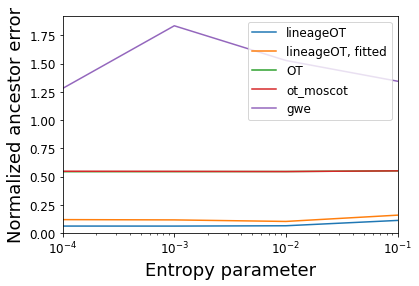

In [25]:
%%time
# Plot accuracy of ancestor prediction
ancestor_errors = plot_metrics(
    couplings,
    lambda x:sim_inf.OT_cost(x, early_time_rna_cost),
    'Normalized ancestor error',
    epsilons,
    keys=["lineageOT", "lineageOT, fitted", "OT", "ot_moscot","gwe"],
    scale = ind_ancestor_error, points=False
)

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 0.0007067738061254936
  warnings.warn(("Expanded coupling not computed correctly. " +
/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 0.1795532403037845
  warnings.warn(("Expanded coupling not computed correctly. " +
/home/michal/.m

CPU times: user 16.3 s, sys: 11.3 s, total: 27.6 s
Wall time: 11.5 s


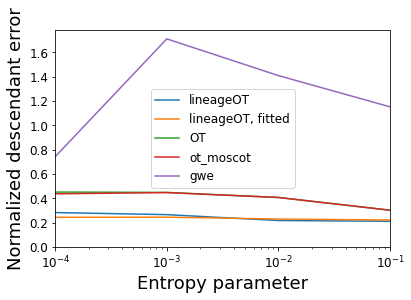

In [26]:
%%time
# Plot accuracy of descendant prediction
descendant_errors = plot_metrics(
    couplings,
    lambda x:sim_inf.OT_cost(sim_eval.expand_coupling(x, couplings['true'], late_time_rna_cost), late_time_rna_cost),
    'Normalized descendant error',
    epsilons,
    keys=["lineageOT", "lineageOT, fitted", "OT", "ot_moscot","gwe"],
    scale = ind_descendant_error
)

### Evaluating the accuracy of the fitted tree

In [27]:
%time fitted_tree_distances = sim_inf.compute_tree_distances(fitted_tree)

CPU times: user 1min 24s, sys: 52.6 ms, total: 1min 24s
Wall time: 1min 24s


Correlation:  0.7597370173973276
Robinson-Foulds tree accuracy:  0.6888454011741683


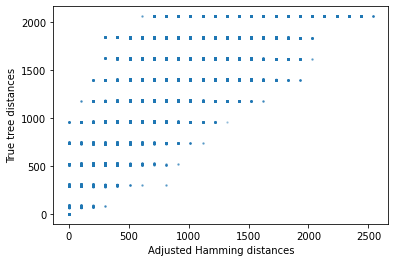

In [28]:
# Plotting the accuracy of tree distances estimated by Hamming distance between barcodes

hamming_distances = (hamming_distances_with_roots['late'][np.triu_indices(num_cells['late'])])/rate_estimate
true_tree_distances = true_distances['late'][np.triu_indices(num_cells['late'])]
plt.scatter(hamming_distances,
            true_tree_distances,
            s = 2,
            alpha = 0.3)
plt.ylabel('True tree distances')
plt.xlabel('Adjusted Hamming distances')
print('Correlation: ', np.corrcoef(hamming_distances, true_tree_distances)[0,1])
print('Robinson-Foulds tree accuracy: ', sim_inf.tree_accuracy(fitted_tree, true_trees['late']))

Correlation:  0.8790642342967604
Robinson-Foulds tree accuracy:  0.6888454011741683


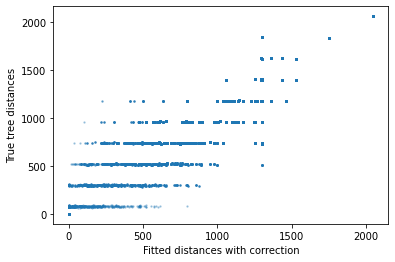

In [29]:
# Plotting the accuracy of tree distances,
# estimated after imposing the constraint that all leaves are the same distance from the root

plt.scatter(fitted_tree_distances[np.triu_indices(num_cells['late'])],
            true_distances['late'][np.triu_indices(num_cells['late'])],
            s = 2,
            alpha = 0.3)
plt.ylabel('True tree distances')
plt.xlabel('Fitted distances with correction')
print('Correlation: ', np.corrcoef(fitted_tree_distances[np.triu_indices(num_cells['late'])],
                                   true_distances['late'][np.triu_indices(num_cells['late'])])[0,1]
     )
print('Robinson-Foulds tree accuracy: ', sim_inf.tree_accuracy(fitted_tree, true_trees['late']))

In [30]:
geom_tl = Geometry(cost_matrix=fitted_tree_distances)

In [31]:
gwt = GW(epsilon=None).fit(geom_rnae, geom_tl)
couplings['gwt'] = np.array(gwt.matrix)
gwt.converged

True


### Coupling sketches

Here we plot the ground-truth, zero-entropy optimal transport, and zero-entropy LineageOT couplings.


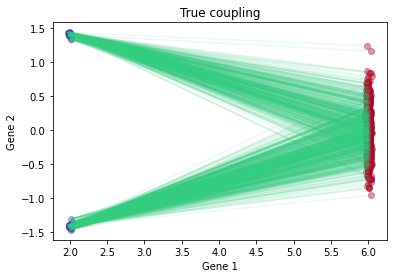

In [32]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['true'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)

plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('True coupling')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

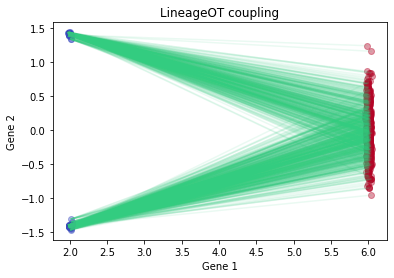

In [33]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['lineageOT'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('LineageOT coupling')

for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

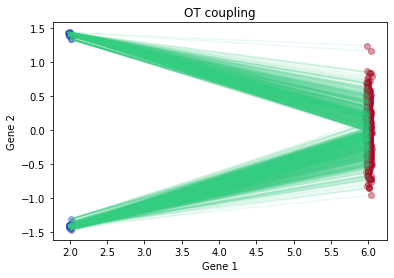

In [34]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['OT'],
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('OT coupling')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

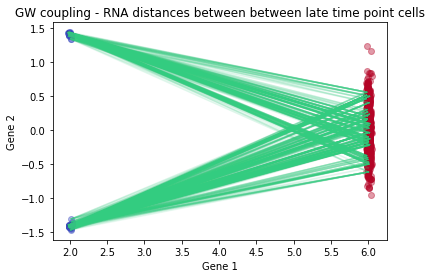

In [35]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['gwl'],
                   thr=np.percentile(couplings['gwl'] / couplings['gwl'].max(), 98),
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('GW coupling - RNA distances between between late time point cells')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

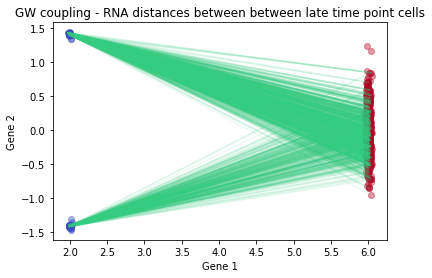

In [36]:
sim_eval.plot2D_samples_mat(rna_arrays['early'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   rna_arrays['late'][:, [dimensions_to_plot[0],dimensions_to_plot[1]]],
                   couplings['gwe'],
                   thr=np.percentile(couplings['gwe'] / couplings['gwe'].max(), 98),
                   c=[0.2, 0.8, 0.5],
                   alpha_scale = 0.1)
plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
plt.title('GW coupling - RNA distances between between late time point cells')


for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
    plt.scatter(a[:, dimensions_to_plot[0]], a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

In [38]:
# gwe - RNA distances in early time point, true tree distances in late
# gwl - vice-versa
# gwt - as gwe, but with fitted tree distances in late time point

res = {"key": [], "early_cost": [], "late_cost": []}
for key, coupling in couplings.items():
    if key == 'true':
        continue
    early_cost = sim_inf.OT_cost(coupling, early_time_rna_cost)
    late_cost = sim_inf.OT_cost(sim_eval.expand_coupling(coupling, couplings['true'], late_time_rna_cost), late_time_rna_cost)
    
    res['key'].append(key)
    res['early_cost'].append(early_cost)
    res['late_cost'].append(late_cost)
res = pd.DataFrame(res).sort_values("key")
res

,key,early_cost,late_cost
0,OT,2.7653319450591036,0.5547920810487371
6,OT 0.0001,2.7666904601854325,0.554643549261814
14,OT 0.001,2.769392942149089,0.5512328507477497
22,OT 0.01,2.773758089873697,0.5002426582731083
30,OT 0.1,2.804819758216025,0.37210758948249884
3,gwe,5.089199027323039,1.2249612558236884
9,gwe 0.0001,6.513587895809609,0.910448993152594
17,gwe 0.001,9.330528315049909,2.095515996256754
25,gwe 0.01,7.7689320660187775,1.7263578527501746
33,gwe 0.1,6.837236228539952,1.4120808041441169
